In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from Setting import Setting
from Dataset import Dataset
from Environment import Environment

import utils.models as models
import utils.metrics as metrics

torch.cuda.is_available()

False

# General settings

In [2]:
# Set the random seed for reproducibility.
random_seed = 1
#tf.random.set_random_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

args = Setting()
args.windowed_dataset = True
device = args.device
dataset = Dataset(args.dataset_path, args.batch_size, args.fast_testing)
padding_number = dataset.num_items
env = Environment(args, dataset, padding_number).to(device)

# Import dataset

In [3]:
train_sep_seq_base_data = env.train_sep_seq_base_data
train_sep_seq_base_data.shape

torch.Size([73353, 20])

In [4]:
test_sep_seq_base_data = env.test_sep_seq_base_data
test_sep_seq_base_data.shape

torch.Size([14077, 20])

In [5]:
train_sep_seq_target_data = env.train_sep_seq_target_data
train_sep_seq_target_data.shape

torch.Size([73353, 1])

In [6]:
train_sep_base_data = env.train_sep_base_data
train_sep_base_data.shape

torch.Size([73353, 18])

In [7]:
test_sep_base_data = env.test_sep_base_data
test_sep_base_data.shape

torch.Size([14077, 18])

In [8]:
true_train_data = train_sep_base_data
masked_multivae_train_data, masked_multivae_train_ref = env.mask_multivae_data(true_train_data)

In [9]:
masked_multivae_train_data.shape

torch.Size([73353, 18])

In [10]:
masked_multivae_train_ref.shape

torch.Size([73353, 18])

In [11]:
true_test_data = test_sep_base_data
masked_multivae_test_data, masked_multivae_test_ref = env.mask_multivae_data(true_test_data)

In [12]:
masked_multivae_test_data.shape

torch.Size([14077, 18])

In [13]:
masked_multivae_test_ref.shape

torch.Size([14077, 18])

In [14]:
train_sep_target_data = env.train_sep_target_data
train_sep_target_data.shape

torch.Size([73353, 18])

In [15]:
test_sep_target_data = env.test_sep_target_data
test_sep_target_data.shape

torch.Size([14077, 18])

In [16]:
true_train_data, masked_train_ref = env.mask_data(train_sep_base_data, train_sep_target_data)
print(true_train_data.shape)
print(masked_train_ref.shape)

torch.Size([73353, 18])
torch.Size([73353, 18])


In [17]:
true_test_data, masked_test_ref = env.mask_data(test_sep_base_data, test_sep_target_data)
print(true_test_data.shape)
print(masked_test_ref.shape)

torch.Size([14077, 18])
torch.Size([14077, 18])


# MultiVAE

In [18]:
learning_rate = 1e-3
weight_decay = 0.00
epochs = 20
n_users = dataset.n_users
n_categories = dataset.n_categories
# The total number of gradient updates for annealing.
anneal_steps = 200000
# Largest annealing parameter. 
anneal_cap = 0.2
batch_size = 256

## Functions

In [19]:
def train():
    # Turn on training mode.
    model.train()
    global update_count
    N = len(train_sep_seq_base_data)
    idxs = list(range(N))
    
    train_loss_list = []
    
    for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        batch_train_data = train_sep_base_data[idxs[start_idx:end_idx]]
        batch_target_data = train_sep_target_data[idxs[start_idx:end_idx]]
        batch_masked_train_data = masked_multivae_train_data[idxs[start_idx:end_idx]]

        # We compute the annealing value. This can be used in the mse_loss
        # to compute the KL divergence as a regularization term.
        if anneal_steps > 0:
            anneal = min(anneal_cap, 1. * update_count / anneal_steps)
        else:
            anneal = anneal_cap

        optimizer.zero_grad()
        # We compute the reconstructed profile and the mean and variance of
        # the distribution.
        batch_recon_data, mu, logvar = model(batch_masked_train_data)
        
        # We compute the loss and update the parameters.
        loss = mse_loss(batch_recon_data, batch_target_data)
        loss.backward()
        train_loss_list.append(loss.item())
        optimizer.step()
        
        # We update the count used for the annealing value.
        update_count += 1
 
    return train_loss_list

In [20]:
def evaluate():
    model.eval()
    global update_count
    N = len(test_sep_seq_base_data)
    idxs = list(range(N))
    
    test_loss_list = []
    recon_data = []
    
    for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        batch_test_data = test_sep_base_data[idxs[start_idx:end_idx]]
        batch_target_data = test_sep_target_data[idxs[start_idx:end_idx]]
        batch_masked_test_data = masked_multivae_test_data[idxs[start_idx:end_idx]]

        # We compute the annealing value. This can be used in the mse_loss
        # to compute the KL divergence as a regularization term.
        if anneal_steps > 0:
            anneal = min(anneal_cap, 1. * update_count / anneal_steps)
        else:
            anneal = anneal_cap
            
        with torch.no_grad():
            # We compute the reconstructed profile and the mean and variance of
            # the distribution.
            batch_recon_data, mu, logvar = model(batch_masked_test_data)
            # We compute the loss but don't update the parameters.
            loss = mse_loss(batch_recon_data, batch_target_data)
            test_loss_list.append(loss.item())

        batch_recon_data = batch_recon_data.detach()
        recon_data.append(batch_recon_data)    
    
    recon_data = torch.vstack(recon_data).to(device)

    # We compute the RMSE values.
    rmse_total, rmse_explicit, rmse_implicit = metrics.rmse_with_mask(test_sep_base_data, masked_multivae_test_data, recon_data, test_sep_target_data, masked_test_ref)
     
    return rmse_total, rmse_explicit, rmse_implicit, test_loss_list

# Train

In [21]:
model_name = 'multivae'
total_time = time.time()

#######################################################################
# Build the model
#######################################################################
p_dims = [8, 16, n_categories]
model = models.MultiVAE(p_dims).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
mse_loss = models.CustomMSE(type="mse_loss")
update_count = 0

#######################################################################
# Training
#######################################################################
train_loss_list, test_loss_list = [], []
rmse_total_list, rmse_explicit_list, rmse_implicit_list = [], [], []
train_times, test_times = [], []
for epoch in range(1, epochs + 1):
    start_train_time = time.time()
    train_loss = train()
    train_loss_list.append(train_loss)
    end_train_time = time.time() - start_train_time
    train_times.append(end_train_time)
    
    start_test_time = time.time()
    rmse_total, rmse_explicit, rmse_implicit, test_loss = evaluate()
    rmse_total_list.append(rmse_total)
    rmse_explicit_list.append(rmse_explicit)
    rmse_implicit_list.append(rmse_implicit)
    test_loss_list.append(test_loss)
    end_test_time = time.time() - start_test_time
    test_times.append(end_test_time)
    
    print("| Epoch {:d} | Total RMSE: {:5.4f} ± {:5.4f} | "
          "Explicit RMSE: {:5.4f} ± {:5.4f} | "
          "Implicit RMSE: {:5.4f} ± {:5.4f} | ".
          format(epoch, torch.mean(rmse_total), torch.std(rmse_total),
                 torch.mean(rmse_explicit), torch.std(rmse_explicit),
                 torch.mean(rmse_implicit), torch.std(rmse_implicit)))
    
print("| Total time: {:5.4f} s. | Train time: {:5.4f} s. | "
      "Test time: {:5.4f} s. | ".
      format(np.sum(np.concatenate((train_times, test_times), axis=0)), 
             np.sum(train_times), 
             np.sum(test_times))) 

with open('./models/model_multivae_predict_win_sep.pt', 'wb') as file:
    torch.save(model.state_dict(), file)

| Epoch 1 | Total RMSE: 0.9259 ± 0.3799 | Explicit RMSE: 0.9162 ± 0.3494 | Implicit RMSE: 1.2334 ± 0.8421 | 
| Epoch 2 | Total RMSE: 0.8464 ± 0.3137 | Explicit RMSE: 0.8421 ± 0.2994 | Implicit RMSE: 1.0891 ± 0.7132 | 
| Epoch 3 | Total RMSE: 0.8206 ± 0.2882 | Explicit RMSE: 0.8192 ± 0.2813 | Implicit RMSE: 1.0014 ± 0.6686 | 
| Epoch 4 | Total RMSE: 0.8072 ± 0.2793 | Explicit RMSE: 0.8080 ± 0.2762 | Implicit RMSE: 0.9622 ± 0.6319 | 
| Epoch 5 | Total RMSE: 0.7995 ± 0.2774 | Explicit RMSE: 0.8007 ± 0.2765 | Implicit RMSE: 0.9471 ± 0.6134 | 
| Epoch 6 | Total RMSE: 0.7945 ± 0.2752 | Explicit RMSE: 0.7959 ± 0.2743 | Implicit RMSE: 0.9458 ± 0.6091 | 
| Epoch 7 | Total RMSE: 0.7916 ± 0.2768 | Explicit RMSE: 0.7931 ± 0.2761 | Implicit RMSE: 0.9408 ± 0.6069 | 
| Epoch 8 | Total RMSE: 0.7900 ± 0.2774 | Explicit RMSE: 0.7916 ± 0.2766 | Implicit RMSE: 0.9372 ± 0.6078 | 
| Epoch 9 | Total RMSE: 0.7884 ± 0.2782 | Explicit RMSE: 0.7901 ± 0.2775 | Implicit RMSE: 0.9353 ± 0.6058 | 
| Epoch 10 | Total 

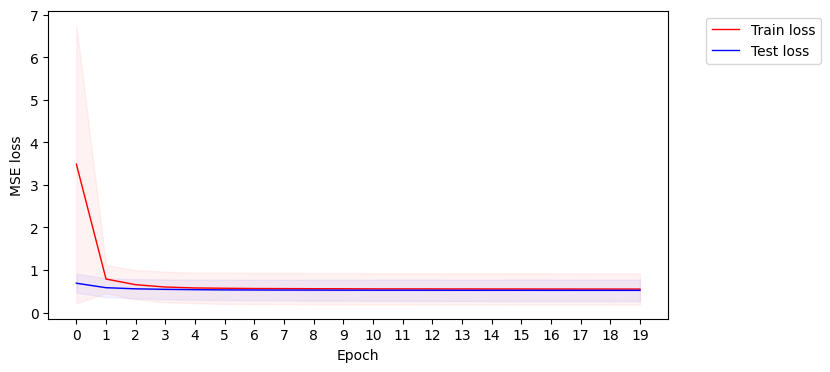

In [22]:
epochs_list = np.arange(epochs)
mean_train_loss = np.mean(train_loss_list, axis=1)
std_train_loss = np.std(train_loss_list, axis=1)
std_low_train_loss = mean_train_loss - std_train_loss
std_high_train_loss = mean_train_loss + std_train_loss

mean_test_loss = np.mean(test_loss_list, axis=1)
std_test_loss = np.std(test_loss_list, axis=1)
std_low_test_loss = mean_test_loss - std_test_loss
std_high_test_loss = mean_test_loss + std_test_loss

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(mean_train_loss, c='r', label='Train loss', linewidth=1.0)
axs.fill_between(epochs_list, mean_train_loss, std_low_train_loss, color='r', alpha=.05)
axs.fill_between(epochs_list, mean_train_loss, std_high_train_loss, color='r', alpha=.05)
plt.plot(mean_test_loss, c='b', label='Test loss', linewidth=1.0)
axs.fill_between(epochs_list, mean_test_loss, std_low_test_loss, color='b', alpha=.05)
axs.fill_between(epochs_list, mean_test_loss, std_high_test_loss, color='b', alpha=.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xticks(np.arange(epochs_list.min(), epochs_list.max()+1, 1.0))
plt.show()

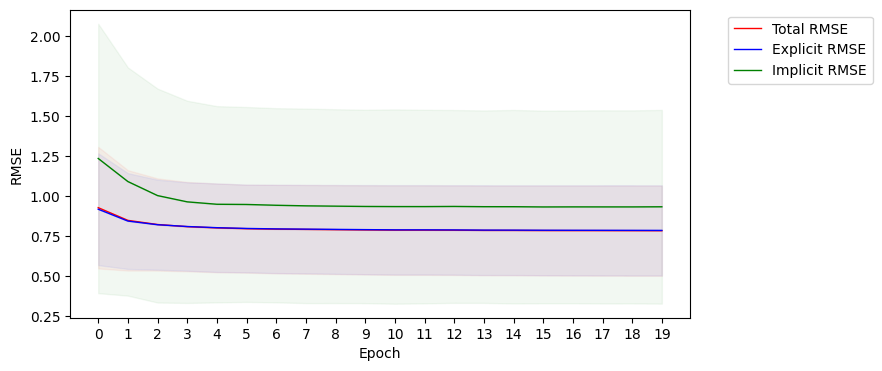

In [23]:
rmse_total_list = torch.vstack(rmse_total_list)
mean_rmse_total = torch.mean(rmse_total_list, dim=1)
std_rmse_total = torch.std(rmse_total_list, dim=1)
std_low_rmse_total = mean_rmse_total - std_rmse_total
std_high_rmse_total = mean_rmse_total + std_rmse_total

rmse_explicit_list = torch.vstack(rmse_explicit_list)
mean_rmse_explicit = torch.mean(rmse_explicit_list, dim=1)
std_rmse_explicit = torch.std(rmse_explicit_list, dim=1)
std_low_rmse_explicit = mean_rmse_explicit - std_rmse_explicit
std_high_rmse_explicit = mean_rmse_explicit + std_rmse_explicit

rmse_implicit_list = torch.vstack(rmse_implicit_list)
mean_rmse_implicit = torch.mean(rmse_implicit_list, dim=1)
std_rmse_implicit = torch.std(rmse_implicit_list, dim=1)
std_low_rmse_implicit = mean_rmse_implicit - std_rmse_implicit
std_high_rmse_implicit = mean_rmse_implicit + std_rmse_implicit

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(mean_rmse_total, c='r', label='Total RMSE', linewidth=1.0)
axs.fill_between(epochs_list, mean_rmse_total, std_low_rmse_total, color='r', alpha=.05)
axs.fill_between(epochs_list, mean_rmse_total, std_high_rmse_total, color='r', alpha=.05)
plt.plot(mean_rmse_explicit, c='b', label='Explicit RMSE', linewidth=1.0)
axs.fill_between(epochs_list, mean_rmse_explicit, std_low_rmse_explicit, color='b', alpha=.05)
axs.fill_between(epochs_list, mean_rmse_explicit, std_high_rmse_explicit, color='b', alpha=.05)
plt.plot(mean_rmse_implicit, c='g', label='Implicit RMSE', linewidth=1.0)
axs.fill_between(epochs_list, mean_rmse_implicit, std_low_rmse_implicit, color='g', alpha=.05)
axs.fill_between(epochs_list, mean_rmse_implicit, std_high_rmse_implicit, color='g', alpha=.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.xticks(np.arange(epochs_list.min(), epochs_list.max()+1, 1.0))
plt.show()

# Profile building

In [24]:
# Profile building for the users of the train set. 
N = len(train_sep_seq_base_data)
idxs = list(range(N))
train_sep_seq_base_profiles = []
for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
    end_idx = min(start_idx + batch_size, N)
    batch_train_data = train_sep_base_data[idxs[start_idx:end_idx]]
    batch_masked_train_data = masked_multivae_train_data[idxs[start_idx:end_idx]]

    # We compute the annealing value. This can be used in the mse_loss
    # to compute the KL divergence as a regularization term.
    if anneal_steps > 0:
        anneal = min(anneal_cap, 1. * update_count / anneal_steps)
    else:
        anneal = anneal_cap
    
    with torch.no_grad():
        # We compute the reconstructed profile and the mean and variance of
        # the distribution.
        batch_recon_data, mu, logvar = model(batch_masked_train_data)
        train_sep_seq_base_profiles.append(batch_recon_data)    
train_sep_seq_base_profiles = torch.vstack(train_sep_seq_base_profiles).to(device)
train_sep_seq_base_profiles = train_sep_seq_base_profiles.numpy()

# Profile building for the users of the test set.
N = len(test_sep_seq_base_data)
idxs = list(range(N))
test_sep_seq_base_profiles = []
for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
    end_idx = min(start_idx + batch_size, N)
    batch_test_data = test_sep_base_data[idxs[start_idx:end_idx]]
    batch_masked_test_data = masked_multivae_test_data[idxs[start_idx:end_idx]]

    # We compute the annealing value. This can be used in the mse_loss
    # to compute the KL divergence as a regularization term.
    if anneal_steps > 0:
        anneal = min(anneal_cap, 1. * update_count / anneal_steps)
    else:
        anneal = anneal_cap
    
    with torch.no_grad():
        # We compute the reconstructed profile and the mean and variance of
        # the distribution.
        batch_recon_data, mu, logvar = model(batch_masked_test_data)
        test_sep_seq_base_profiles.append(batch_recon_data)    
test_sep_seq_base_profiles = torch.vstack(test_sep_seq_base_profiles).to(device)
test_sep_seq_base_profiles = test_sep_seq_base_profiles.numpy()

dataframe_train_seq_base_profiles = pd.DataFrame(train_sep_seq_base_profiles)
dataframe_train_seq_base_profiles.to_csv(f"{dataset.dataset_path}/preprocessed/train_sep_profiles_multivae_predict_win.csv", index=False)
dataframe_test_seq_base_profiles = pd.DataFrame(test_sep_seq_base_profiles)
dataframe_test_seq_base_profiles.to_csv(f"{dataset.dataset_path}/preprocessed/test_sep_profiles_multivae_predict_win.csv", index=False)